In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV


In [2]:
# Ingesting the csv dataset
df = pd.read_csv('https://github.com/nataliea30/DiabetesML/blob/34862282fc8283b4ff686564763586c3a63bdcdd/diabetes_prediction_dataset.csv?raw=true')


In [3]:
# Printing the DataFrame head and information
print(df.head())
df.info()

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age               

In [4]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

# Counting the number of distinct values in each column
num_distinct_values = df.nunique()
print(num_distinct_values)

# Checking null values
print(df.isnull().sum())

# Removing the 'Other' category from the 'gender' column
df = df[df['gender'] != 'Other']

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [5]:
# Define a function to map the existing categories to new ones in order to reduce to 3 main categories of smoking
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df.loc[:, 'smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())


non-smoker     67276
past_smoker    19655
current         9197
Name: smoking_history, dtype: int64


In [6]:
data = df.copy()

In [7]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

In [9]:
print(data.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Female  gender_Male  smoking_history_current  \
0         0              1            0                        0   
1         0              1            0                        0   
2         0              0            1                        0   
3         0              1            0                        1   
4         0              0            1                        1   

   smoking_history_non-smoker  smoking_history_past_smoker  
0                           1              

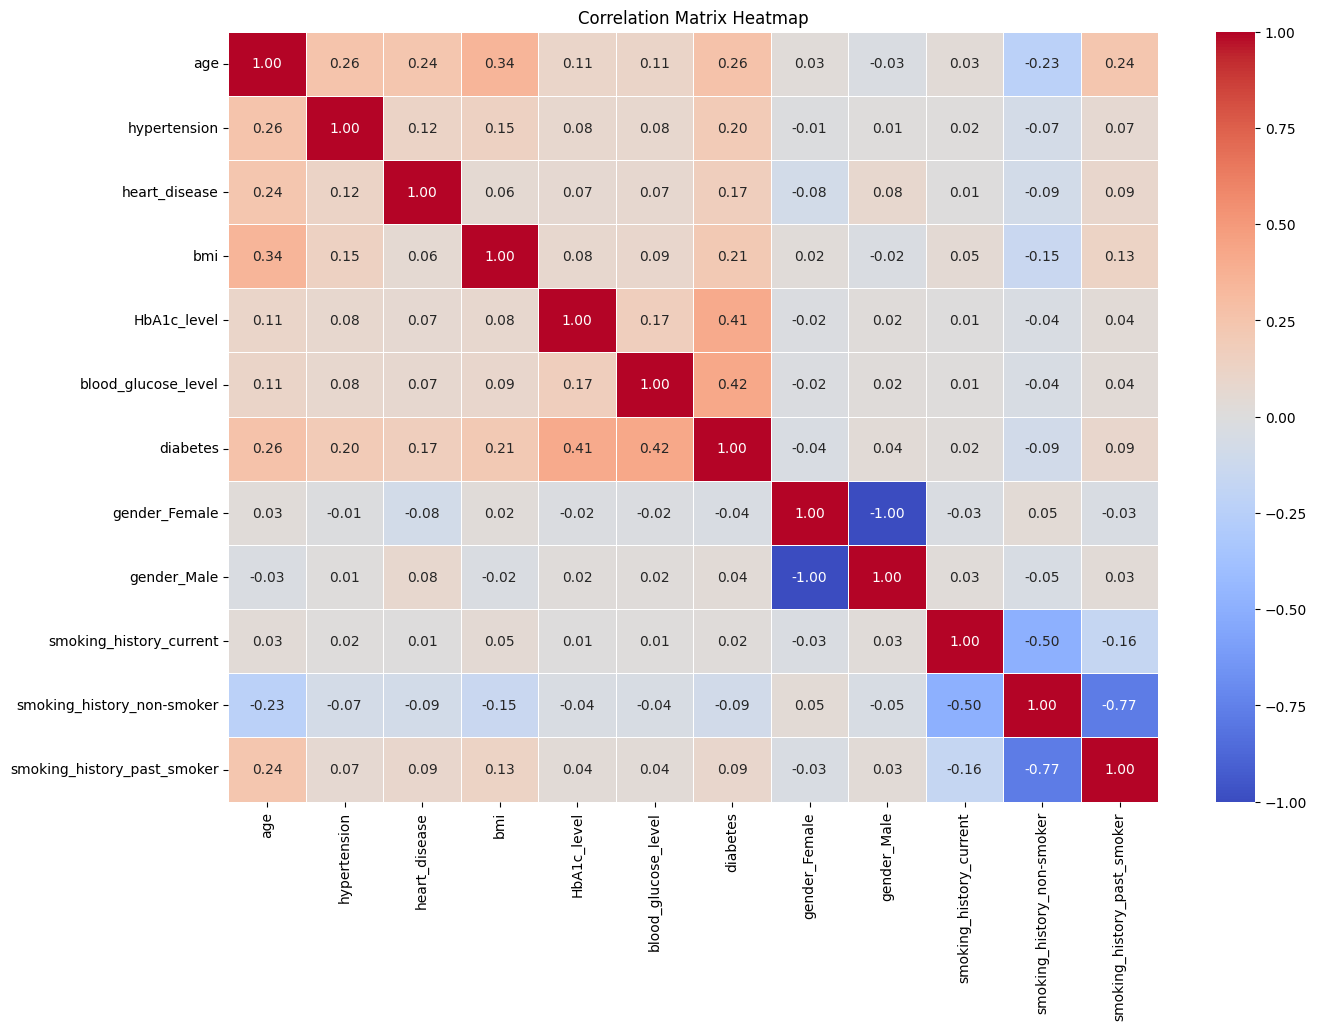

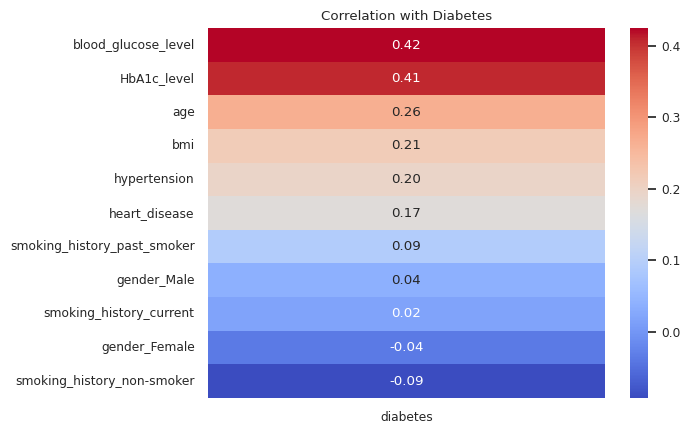

In [10]:
# Compute the correlation matrix
correlation_matrix = data.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

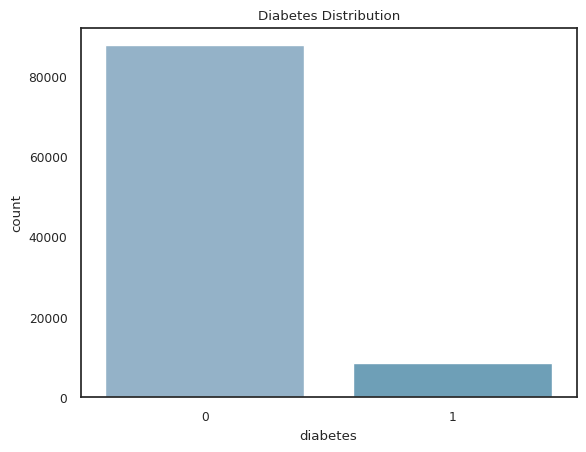

In [12]:
#data is unbalanced, 91% negative to 9% positive
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [65]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age','bmi', 'HbA1c_level', 'blood_glucose_level']),
        ('cat', OneHotEncoder(), ['gender_Female', 'gender_Male', 'smoking_history_current', 'smoking_history_non-smoker', 'smoking_history_past_smoker'])
    ])


# Create resampling objects
over = SMOTE()
under = RandomUnderSampler()

# Split data into features and target variable
X = data.drop('diabetes', axis=1)
y = data['diabetes']

# Preprocess the data, oversample, and undersample
X_preprocessed = preprocessor.fit_transform(X)

X_resampled, y_resampled = over.fit_resample(X_preprocessed, y)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# Split resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Create and train the classifier
clf = RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10)

Model Accuracy:  0.8939216748908982
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     17530
           1       0.90      0.88      0.89     17529

    accuracy                           0.89     35059
   macro avg       0.89      0.89      0.89     35059
weighted avg       0.89      0.89      0.89     35059



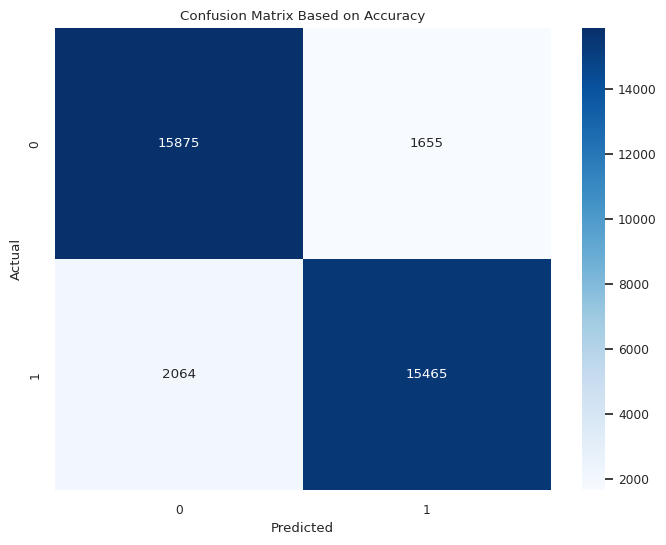

In [67]:
# Predict on the test set using the trained classifier
y_pred_resampled = clf.predict(X_test)

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred_resampled))
print(classification_report(y_test, y_pred_resampled))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_resampled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Based on Accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The following is another Random Decision Classification Model optimized based on recall.


In [68]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']),
        ('cat', OneHotEncoder(), ['gender_Female', 'gender_Male', 'smoking_history_current', 'smoking_history_non-smoker', 'smoking_history_past_smoker'])
    ])

# Create resampling objects
over = SMOTE()
under = RandomUnderSampler()

# Split data into features and target variable
X = data.drop('diabetes', axis=1)
y = data['diabetes']

# Preprocess the data, oversample, and undersample
X_preprocessed = preprocessor.fit_transform(X)

X_resampled, y_resampled = over.fit_resample(X_preprocessed, y)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# Split resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Create and train the classifier
clf = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10)

Model Recall Score:  0.8717553768041532
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     17530
           1       0.91      0.87      0.89     17529

    accuracy                           0.89     35059
   macro avg       0.89      0.89      0.89     35059
weighted avg       0.89      0.89      0.89     35059



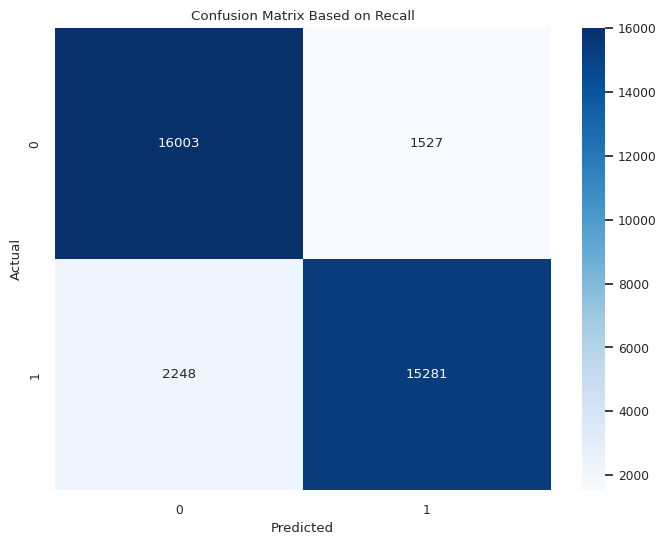

In [69]:
# Predict on the test set using the trained classifier
y_pred_resampled = clf.predict(X_test)

# Evaluate the model
print("Model Recall Score: ", recall_score(y_test, y_pred_resampled))
print(classification_report(y_test, y_pred_resampled))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_resampled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Based on Recall')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()